In [1]:
#  Part of the LLVM Project, under the Apache License v2.0 with LLVM Exceptions.
#  See https://llvm.org/LICENSE.txt for license information.
#  SPDX-License-Identifier: Apache-2.0 WITH LLVM-exception

## Setup

### Configuring jupyter kernel.

We assume that you have followed the instructions for setting up npcomp. See [README.md](https://github.com/llvm/torch-mlir) if not.

To run this notebook, you need to configure jupyter to access the npcomp Python modules that are built as part of your development setup. An easy way to do this is to run the following command with the same Python (and shell) that is correctly set up and able to run the npcomp end-to-end tests with refbackend:

```shell
python -m ipykernel install --user --name=npcomp --env PYTHONPATH "$PYTHONPATH"
```

You should then have an option in jupyter to select this kernel for running this notebook.

**TODO**: Make this notebook standalone and work based entirely on pip-installable packages.




### Additional dependencies for this notebook

In [ ]:
!python -m pip install requests pillow

## Imports

### Npcomp imports

In [3]:
import torch
import torchvision

from torch_mlir.dialects.torch.importer.jit_ir import ClassAnnotator, ModuleBuilder
from torch_mlir.dialects.torch.importer.jit_ir.torchscript_annotations import extract_annotations
from npcomp_torchscript.annotations import annotate_args, export

import npcomp
from npcomp.passmanager import PassManager
from npcomp.compiler.pytorch.backend import refbackend

### General dependencies

In [4]:
import requests
from PIL import Image

### Utilities

In [5]:
def compile_module(program: torch.nn.Module):
    """Compiles a torch.nn.Module into an compiled artifact.
    
    This artifact is suitable for inclusion in a user's application. It only
    depends on the rebackend runtime.
    """
    ## Script the program.
    scripted = torch.jit.script(program)

    ## Extract annotations.
    class_annotator = ClassAnnotator()
    extract_annotations(program, scripted, class_annotator)

    ## Import the TorchScript module into MLIR.
    mb = ModuleBuilder()
    mb.import_module(scripted._c, class_annotator)

    ## Lower the MLIR from TorchScript to refbackend, passing through npcomp's backend contract.
    with npcomp.ir.Context() as ctx:
        npcomp.register_all_dialects(ctx)
        lowered_mlir_module = npcomp.ir.Module.parse(str(mb.module))
        pm = PassManager.parse('torchscript-to-npcomp-backend-pipeline')
        pm.run(lowered_mlir_module)

    ## Invoke refbackend to compile to compiled artifact form.
    backend = refbackend.RefBackendNpcompBackend()
    return backend.compile(lowered_mlir_module)

## Basic tanh module

A simple tiny module that is easier to understand and look at than a full ResNet.

In [6]:
class TanhModule(torch.nn.Module):
    def __init__(self):
        super().__init__()

    # The `export` annotation controls which parts of the model the npcomp
    # compiler should assume are externally accessible. By default,
    # the npcomp compiler will only export the explicitly exported functions.
    # NOTE: THis is different from `torch.jit.export`. The `torch.jit.export`
    # decorator controls which methods of the original torch.nn.Module get
    # compiled into TorchScript. This decorator
    # (`npcomp_torchscript.annotations.export`) controls which TorchScript
    # methods are compiled by npcomp. 
    @export
    # The `annotate_args` annotation provides metadata to the npcomp compiler
    # regarding the constraints on arguments. The value `None` means that
    # no additional information is provided for that argument. Otherwise,
    # it is a 3-tuple specifying the shape (`-1` for unknown extent along a dimension),
    # along with the dtype and whether the tensor has
    # value semantics (this would be False if you need to mutate an input
    # tensor in-place).
    @annotate_args([
        None,
        ([-1], torch.float32, True)
    ])
    def forward(self, a):
        return torch.tanh(a)

In [7]:
# Create the module and compile it.
compiled = compile_module(TanhModule())
# Loads the compiled artifact into the runtime
jit_module = refbackend.RefBackendNpcompBackend().load(compiled)
# Run it!
jit_module.forward(torch.tensor([-1.0, 1.0, 0.0]).numpy())

array([-0.7615941,  0.7615941,  0.       ], dtype=float32)

## ResNet Inference

Do some one-time preparation.

In [8]:
def _load_labels():
    classes_text = requests.get(
        "https://raw.githubusercontent.com/cathyzhyi/ml-data/main/imagenet-classes.txt",
        stream=True,
    ).text
    labels = [line.strip() for line in classes_text.splitlines()]
    return labels
IMAGENET_LABELS = _load_labels()

def _get_preprocess_transforms():
    # See preprocessing specification at: https://pytorch.org/vision/stable/models.html
    T = torchvision.transforms
    return T.Compose(
        [
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )
PREPROCESS_TRANSFORMS = _get_preprocess_transforms()

Define some helper functions.

In [9]:
def fetch_image(url: str):
    # Use some "realistic" User-Agent so that we aren't mistaken for being a scraper.
    headers = {"User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.131 Safari/537.36"}
    return Image.open(requests.get(url, headers=headers, stream=True).raw).convert("RGB")

def preprocess_image(img: Image):
    # Preprocess and add a batch dimension.
    return torch.unsqueeze(PREPROCESS_TRANSFORMS(img), 0)

### Fetch our sample image.

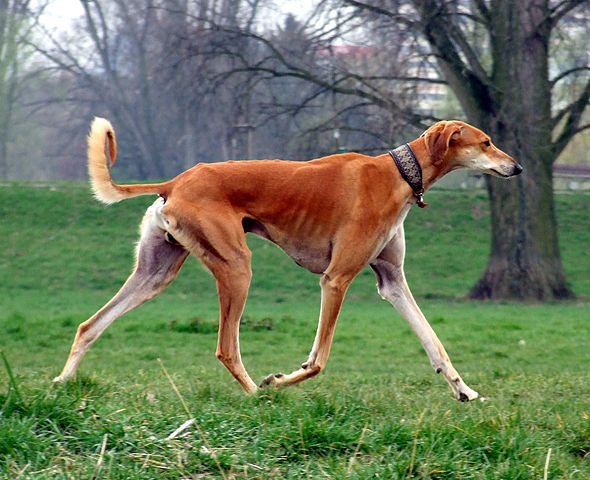

In [10]:
img = fetch_image("https://upload.wikimedia.org/wikipedia/commons/thumb/3/31/Red_Smooth_Saluki.jpg/590px-Red_Smooth_Saluki.jpg")
img_preprocessed = preprocess_image(img)

img

### Define the module and compile it

In [11]:
class ResNet18Module(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = torchvision.models.resnet18(pretrained=True)
        self.train(False)
    @export
    @annotate_args([
        None,
        ([1, 3, 224, 224], torch.float32, True),
    ])
    def forward(self, img):
        return self.resnet.forward(img)

In [ ]:
# Create the module and compile it.
compiled = compile_module(ResNet18Module())
# Load it for in-process execution.
jit_module = refbackend.RefBackendNpcompBackend().load(compiled)

### Execute the classification!

In [ ]:
logits = torch.from_numpy(jit_module.forward(img_preprocessed.numpy()))

In [ ]:
# Npcomp doesn't currently support these final postprocessing operations, so perform them in Torch.
def top3_possibilities(logits):
    _, indexes = torch.sort(logits, descending=True)
    percentage = torch.nn.functional.softmax(logits, dim=1)[0] * 100
    top3 = [(IMAGENET_LABELS[idx], percentage[idx].item()) for idx in indexes[0][:3]]
    return top3

In [52]:
top3_possibilities(logits)

[('Saluki, gazelle hound', 75.50347900390625),
 ('Ibizan hound, Ibizan Podenco', 17.549449920654297),
 ('whippet', 6.24681282043457)]